In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import json
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.utils import mask_to_categorical
from stardist.plot import render_label

import matplotlib.colors as mcolors
import copy

np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab20


def cus_plot_img_label(X_main, lbl, cls_dict):
    X_modified = X_main.copy()  # Create a copy of the input image

    c = mask_to_categorical(lbl, n_classes=4, classes=cls_dict)
    res = np.argmax(c, axis=-1).astype(np.uint16)

    colors = {
        1: (59 / 255, 154 / 255, 251 / 255),   # Blue for mask value 1
        2: (0 / 255, 255 / 255, 61 / 255),     # Green for mask value 2
        3: (250 / 255, 220 / 255, 57 / 255),   # Yellow for mask value 3
        4: (255 / 255, 0 / 255, 23 / 255)      # Red for mask value 4
    }

    h, w = res.shape[:2]
    mask_values = np.unique(res)

    for mask_value in mask_values:
        if mask_value in colors:
            color = colors[mask_value]
            mask = res == mask_value
            X_modified[mask] = color

    return X_modified


def plot_all(img, lbl, cls_dict, img_title="ROI", lbl_title="Ground truth", cls_title="Ground truth by Classs", font_size=18, **kwargs):
    
    plot_img=cus_plot_img_label(img,lbl,cls_dict)
    
    
    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title, fontsize=font_size)    
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title, fontsize=font_size)
    ac.imshow(plot_img)
    ac.set_title(cls_title, fontsize=font_size)
    plt.tight_layout()    
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac

C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
transport.py (219): Blowfish has been deprecated


In [2]:
# set the number of object classes
n_classes = 4

In [3]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm

def make_image(folder_paths, height, width):
    
    new_image = np.zeros((height, width), dtype=np.uint8)
    
    my_dict = {}

    class_name_reco = {
        'Blue': 1,
        'Green': 2,
        'Yellow': 3,
        'Red': 4
    }
    for i, path in enumerate(folder_paths):
        
        class_name= path.split('\\')[-1].split('_')[-2]
        reference_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        reference_image = cv2.resize(reference_image, (width, height))
        new_image[reference_image > 0 ] = i+1
        my_dict[i+1] = class_name_reco[class_name]
        
        
    return new_image, my_dict


    
X_test=[]
Y_test=[]
C_test=[]
for path in tqdm(os.listdir(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing')):
    roi=io.imread(glob.glob(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing/'+path+'/image/*.png')[0])
    height, width, _ = roi.shape
    #height, width, _ = [256,256,3]
    roi = transform.resize(roi, (height, width))
    
    folder_paths= glob.glob(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing/'+path+'/color_masks/*.png')
    one_image, my_dict=make_image(folder_paths, height, width)
    
    X_test.append(roi)
    Y_test.append(one_image)
    C_test.append(my_dict)

100%|██████████| 44/44 [00:08<00:00,  4.91it/s]


(<Axes: title={'center': 'ROI'}>,
 <Axes: title={'center': 'Ground truth'}>,
 <Axes: title={'center': 'Ground truth by Classs'}>)

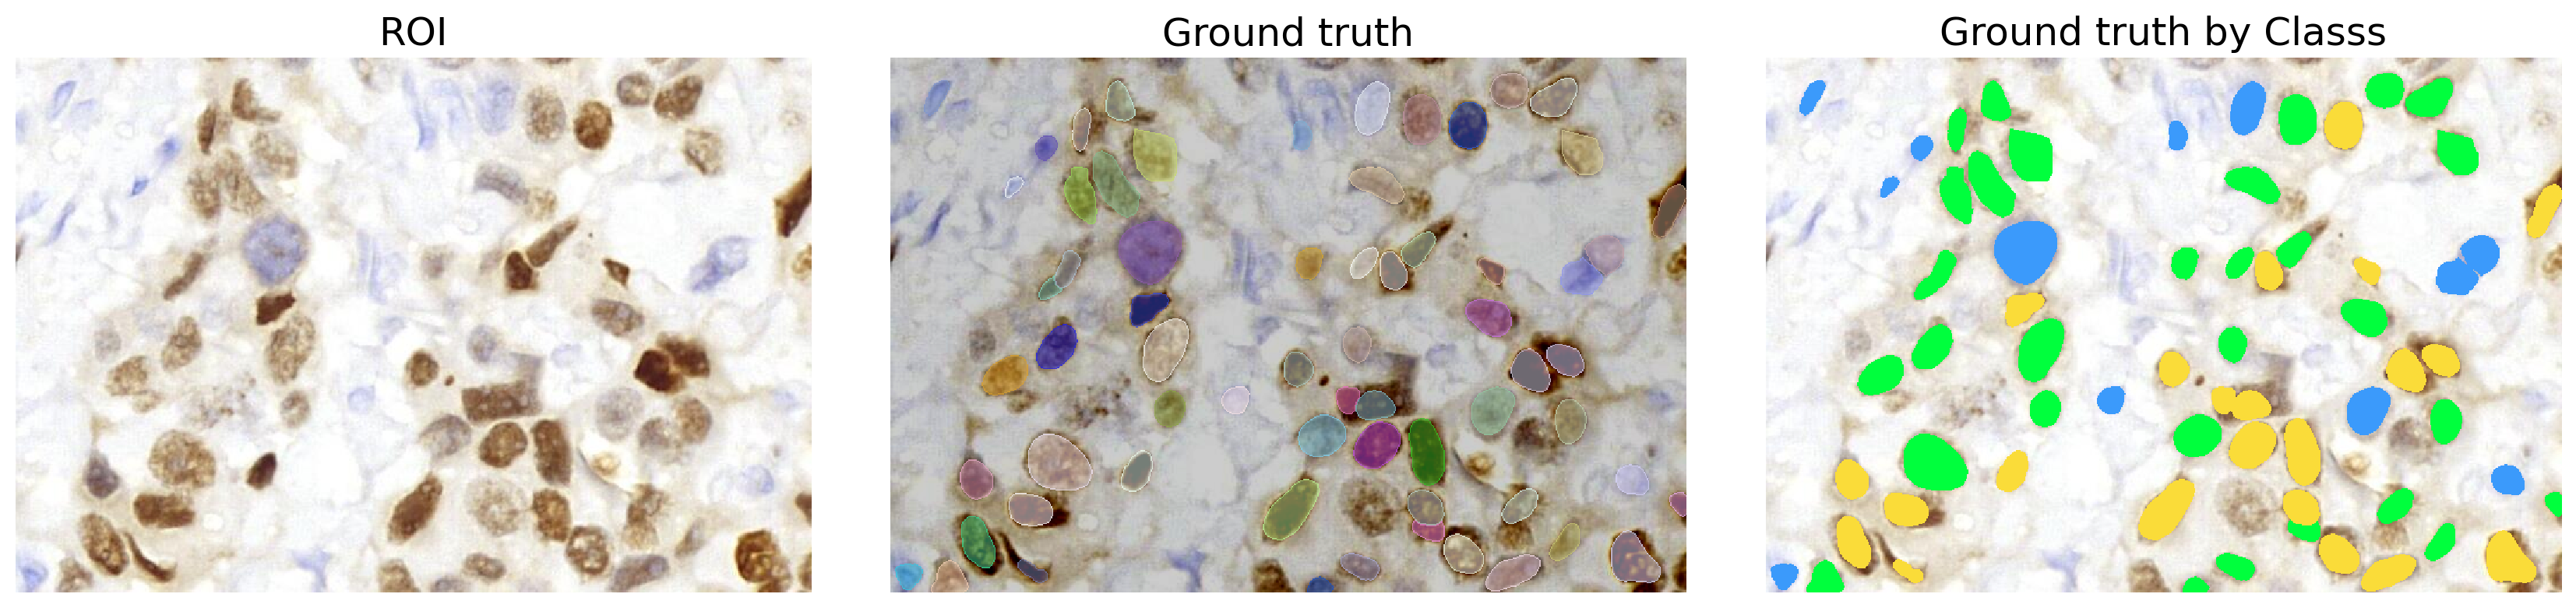

In [4]:
valuesss=24
plot_all(X_test[valuesss],Y_test[valuesss], C_test[valuesss])

In [5]:
model = StarDist2D(None, name='resnetsegnet_multiclass_ai4dp', basedir='models')

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   896         ['input[0][0]']                  
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   9248        ['conv2d[0][0]']                 
                                32)                                                        

                                                                                                  
 conv2_block2_2_relu (Activatio  (None, None, None,   0          ['conv2_block2_2_bn[0][0]']      
 n)                             64)                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, None, None,   16640       ['conv2_block2_2_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, None, None,   1024       ['conv2_block2_3_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, None, None,   0          ['conv3_block2_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, None, None,   147584      ['conv3_block2_1_relu[0][0]']    
                                128)                                                              
          

 conv3_block4_add (Add)         (None, None, None,   0           ['conv3_block3_out[0][0]',       
                                512)                              'conv3_block4_3_bn[0][0]']      
                                                                                                  
 conv3_block4_out (Activation)  (None, None, None,   0           ['conv3_block4_add[0][0]']       
                                512)                                                              
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, None, None,   131328      ['conv3_block4_out[0][0]']       
                                256)                                                              
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block3_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, None, None,   0          ['conv4_block3_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block3_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, None, None,   0          ['conv4_block6_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block6_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block6_2_conv[0][0]']    
 ization)                       256)                                                              
          

 conv5_block2_3_bn (BatchNormal  (None, None, None,   8192       ['conv5_block2_3_conv[0][0]']    
 ization)                       2048)                                                             
                                                                                                  
 conv5_block2_add (Add)         (None, None, None,   0           ['conv5_block1_out[0][0]',       
                                2048)                             'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, None, None,   0           ['conv5_block2_add[0][0]']       
                                2048)                                                             
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
          

                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, None, None,   36928       ['conv2_block1_1_relu[0][0]']    
                                64)                                                               
                                                                                                  
 conv2_block1_2_bn (BatchNormal  (None, None, None,   256        ['conv2_block1_2_conv[0][0]']    
 ization)                       64)                                                               
                                                                                                  
 conv2_block1_2_relu (Activatio  (None, None, None,   0          ['conv2_block1_2_bn[0][0]']      
 n)                             64)                                                               
                                                                                                  
 conv2_blo

                                256)                              'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, None, None,   0           ['conv2_block3_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, None, None,   32896       ['conv2_block3_out[0][0]']       
                                128)                                                              
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block1_1_conv[0][0]']    
 ization)                       128)                                                              
          

 conv3_block3_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block3_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, None, None,   0          ['conv3_block3_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block3_2_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, None, None,   2048       ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, None, None,   262400      ['conv4_block1_out[0][0]']       
                                256)                                                              
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block2_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, None, None,   0          ['conv4_block2_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_blo

 ization)                       1024)                                                             
                                                                                                  
 conv4_block4_add (Add)         (None, None, None,   0           ['conv4_block3_out[0][0]',       
                                1024)                             'conv4_block4_3_bn[0][0]']      
                                                                                                  
 conv4_block4_out (Activation)  (None, None, None,   0           ['conv4_block4_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, None, None,   262400      ['conv4_block4_out[0][0]']       
                                256)                                                              
          

 up_sampling2d_1 (UpSampling2D)  (None, None, None,   0          ['batch_normalization_1[0][0]']  
                                256)                                                              
                                                                                                  
 conv2d_4 (Conv2D)              (None, None, None,   295040      ['up_sampling2d_1[0][0]']        
                                128)                                                              
                                                                                                  
 batch_normalization_2 (BatchNo  (None, None, None,   512        ['conv2d_4[0][0]']               
 rmalization)                   128)                                                              
                                                                                                  
 up_sampling2d_2 (UpSampling2D)  (None, None, None,   0          ['batch_normalization_2[0][0]']  
          

In [6]:
model.optimize_thresholds(X_test, Y_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 25ms/step


NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:40<00:13,  2.70s/it, 0.655 -> 0.712]


Using optimized values: prob_thresh=0.648723, nms_thresh=0.4.
Saving to 'thresholds.json'.


{'prob': 0.648723175474446, 'nms': 0.4}

In [7]:
i = 42
label, res = model.predict_instances(X_test[i], n_tiles=model._guess_n_tiles(X_test[i]))


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step



 50%|█████     | 1/2 [00:00<00:00,  2.74it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


In [8]:
# the class object ids are stored in the 'results' dict and correspond to the label ids in increasing order 
def class_from_res(res):
    cls_dict = dict((i+1,c) for i,c in enumerate(res['class_id']))
    return cls_dict


(<Axes: title={'center': 'ROI'}>,
 <Axes: title={'center': 'Predict'}>,
 <Axes: title={'center': 'Predict by Classs'}>)

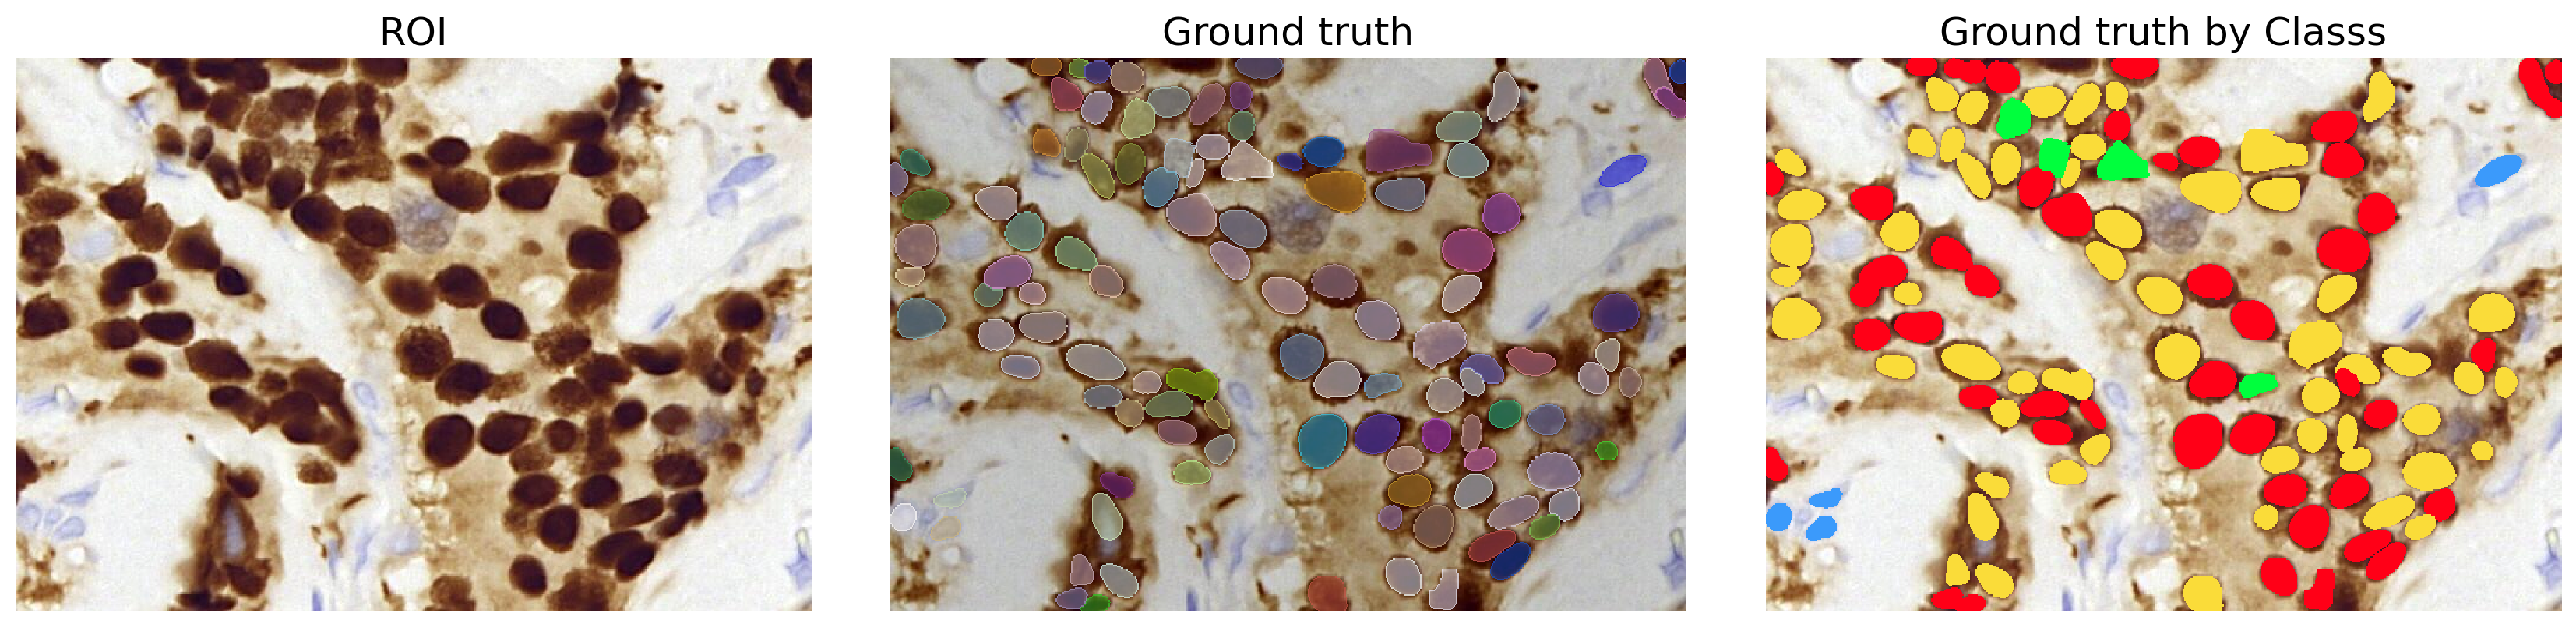

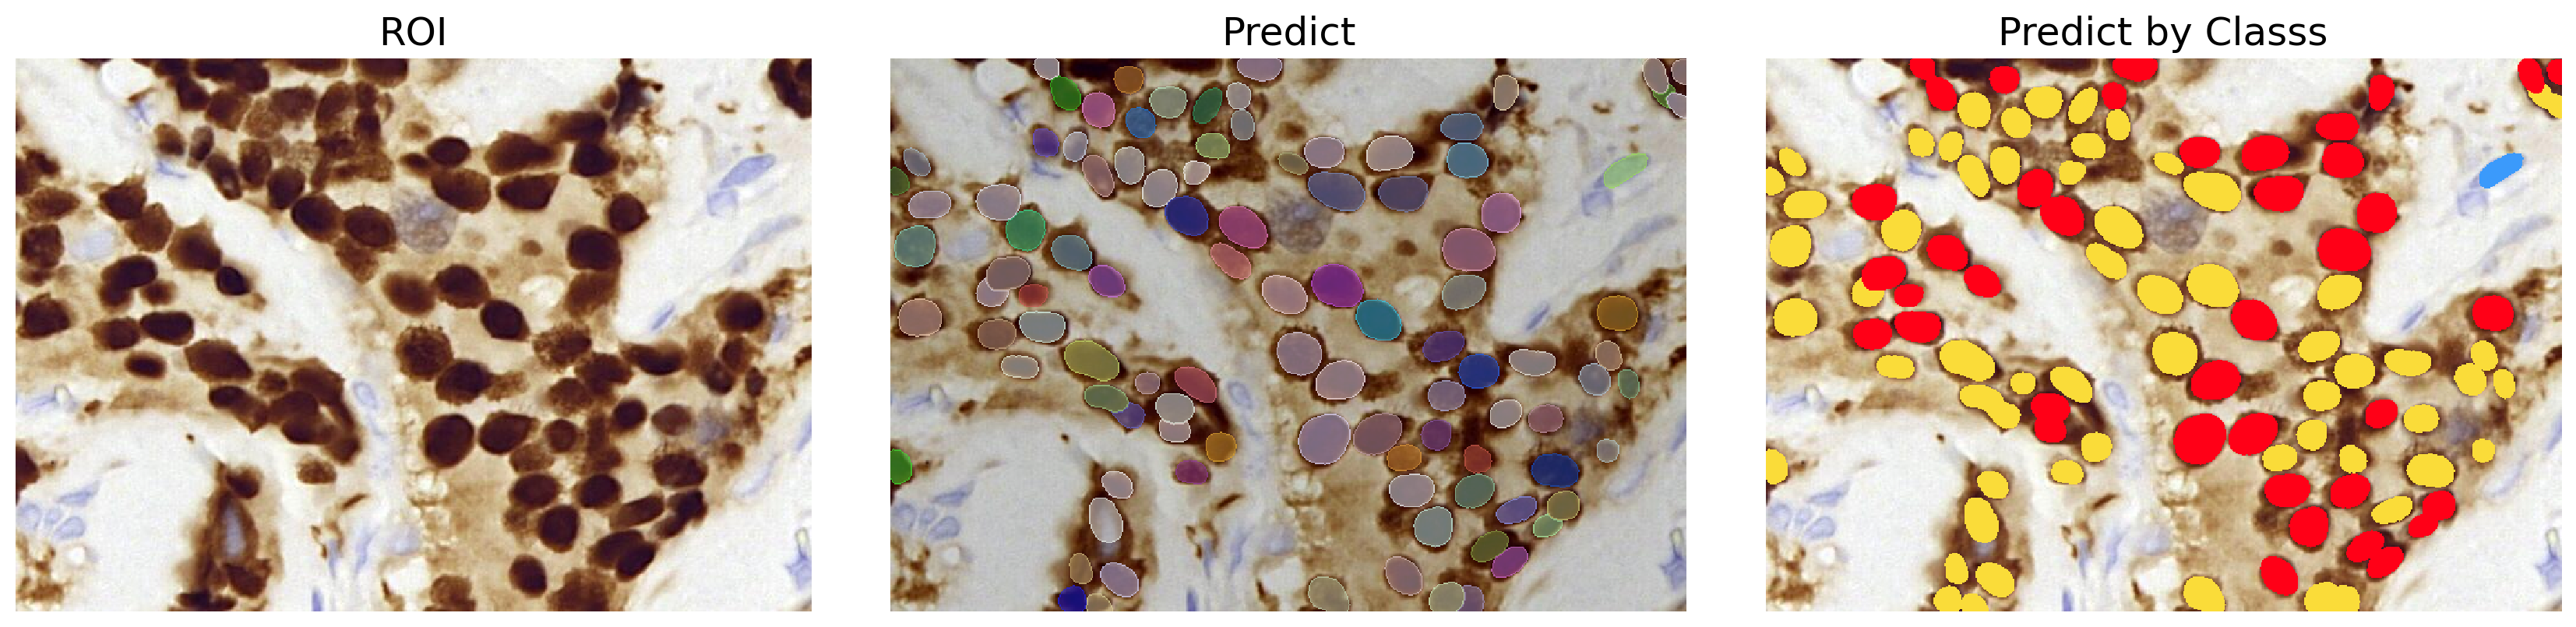

In [9]:
plot_all(X_test[i], Y_test[i], C_test[i],            lbl_title="Ground truth", cls_title="Ground truth by Classs")
plot_all(X_test[i], label,    class_from_res(res), lbl_title="Predict", cls_title="Predict by Classs")

In [10]:
Y_test_pred, res_test_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
              for x in tqdm(X_test[:])]))


  0%|          | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step



  2%|▏         | 1/44 [00:00<00:19,  2.19it/s]

1/1 [==============================] - 0s 24ms/step



  5%|▍         | 2/44 [00:00<00:13,  3.04it/s]

1/1 [==============================] - 0s 24ms/step



  7%|▋         | 3/44 [00:00<00:12,  3.33it/s]

1/1 [==============================] - 0s 26ms/step



  9%|▉         | 4/44 [00:01<00:11,  3.61it/s]

1/1 [==============================] - 0s 22ms/step



 11%|█▏        | 5/44 [00:01<00:11,  3.52it/s]

1/1 [==============================] - 0s 23ms/step



 14%|█▎        | 6/44 [00:01<00:10,  3.62it/s]

1/1 [==============================] - 0s 25ms/step



 16%|█▌        | 7/44 [00:01<00:09,  3.87it/s]

1/1 [==============================] - 0s 23ms/step



 18%|█▊        | 8/44 [00:02<00:09,  3.89it/s]

1/1 [==============================] - 0s 24ms/step



 20%|██        | 9/44 [00:02<00:10,  3.36it/s]

1/1 [==============================] - 0s 23ms/step



 23%|██▎       | 10/44 [00:02<00:10,  3.36it/s]

1/1 [==============================] - 0s 23ms/step



 25%|██▌       | 11/44 [00:03<00:09,  3.34it/s]

1/1 [==============================] - 0s 23ms/step



 27%|██▋       | 12/44 [00:03<00:08,  3.56it/s]

1/1 [==============================] - 0s 24ms/step



 30%|██▉       | 13/44 [00:03<00:10,  3.02it/s]

1/1 [==============================] - 0s 23ms/step



 32%|███▏      | 14/44 [00:04<00:10,  2.83it/s]

1/1 [==============================] - 0s 23ms/step



 34%|███▍      | 15/44 [00:04<00:09,  2.98it/s]

1/1 [==============================] - 0s 23ms/step



 36%|███▋      | 16/44 [00:04<00:09,  2.91it/s]

1/1 [==============================] - 0s 23ms/step



 39%|███▊      | 17/44 [00:05<00:09,  2.78it/s]

1/1 [==============================] - 0s 25ms/step



 41%|████      | 18/44 [00:05<00:09,  2.64it/s]

1/1 [==============================] - 0s 23ms/step



 43%|████▎     | 19/44 [00:06<00:08,  2.85it/s]

1/1 [==============================] - 0s 22ms/step



 45%|████▌     | 20/44 [00:06<00:09,  2.63it/s]

1/1 [==============================] - 0s 23ms/step



 48%|████▊     | 21/44 [00:06<00:08,  2.57it/s]

1/1 [==============================] - 0s 23ms/step



 50%|█████     | 22/44 [00:07<00:08,  2.74it/s]

1/1 [==============================] - 0s 24ms/step



 52%|█████▏    | 23/44 [00:07<00:08,  2.57it/s]

1/1 [==============================] - 0s 24ms/step



 55%|█████▍    | 24/44 [00:08<00:07,  2.52it/s]

1/1 [==============================] - 0s 24ms/step



 57%|█████▋    | 25/44 [00:08<00:06,  2.81it/s]

1/1 [==============================] - 0s 23ms/step



 59%|█████▉    | 26/44 [00:08<00:06,  2.75it/s]

1/1 [==============================] - 0s 23ms/step



 61%|██████▏   | 27/44 [00:09<00:06,  2.57it/s]

1/1 [==============================] - 0s 24ms/step



 64%|██████▎   | 28/44 [00:09<00:05,  2.93it/s]

1/1 [==============================] - 0s 23ms/step



 66%|██████▌   | 29/44 [00:09<00:05,  2.78it/s]

1/1 [==============================] - 0s 23ms/step



 68%|██████▊   | 30/44 [00:10<00:04,  3.05it/s]

1/1 [==============================] - 0s 23ms/step



 70%|███████   | 31/44 [00:10<00:04,  3.23it/s]

1/1 [==============================] - 0s 24ms/step



 73%|███████▎  | 32/44 [00:10<00:04,  2.92it/s]

1/1 [==============================] - 0s 24ms/step



 75%|███████▌  | 33/44 [00:11<00:03,  3.19it/s]

1/1 [==============================] - 0s 23ms/step



 77%|███████▋  | 34/44 [00:11<00:03,  3.02it/s]

1/1 [==============================] - 0s 23ms/step



 80%|███████▉  | 35/44 [00:11<00:03,  2.78it/s]

1/1 [==============================] - 0s 24ms/step



 82%|████████▏ | 36/44 [00:12<00:02,  3.04it/s]

1/1 [==============================] - 0s 23ms/step



 84%|████████▍ | 37/44 [00:12<00:02,  2.84it/s]

1/1 [==============================] - 0s 23ms/step



 86%|████████▋ | 38/44 [00:12<00:01,  3.03it/s]

1/1 [==============================] - 0s 23ms/step



 89%|████████▊ | 39/44 [00:13<00:01,  3.06it/s]

1/1 [==============================] - 0s 23ms/step



 91%|█████████ | 40/44 [00:13<00:01,  3.25it/s]

1/1 [==============================] - 0s 25ms/step



 93%|█████████▎| 41/44 [00:13<00:00,  3.39it/s]

1/1 [==============================] - 0s 25ms/step



 95%|█████████▌| 42/44 [00:13<00:00,  3.36it/s]

1/1 [==============================] - 0s 26ms/step



 98%|█████████▊| 43/44 [00:14<00:00,  3.38it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 44/44 [00:14<00:00,  3.00it/s]


In [11]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_test, Y_test_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


In [12]:
stats[taus.index(0.4)]

DatasetMatching(criterion='iou', thresh=0.4, fp=440, tp=3710, fn=555, precision=0.8939759036144578, recall=0.8698710433763188, accuracy=0.7885228480340064, f1=0.8817587641117053, n_true=4265, n_pred=4150, mean_true_score=0.6886317070874911, mean_matched_score=0.7916480406275336, panoptic_quality=0.6980425979151871, by_image=False)

In [ ]:
for i in range(44):
    plot_all(X_test[i],Y_test[i],      C_test[i],                        lbl_title="Ground truth", cls_title="Ground truth by Classs")
    plot_all(X_test[i],Y_test_pred[i], class_from_res(res_test_pred[i]), lbl_title="Predict", cls_title="Predict by Classs");

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_f1=[]
all_recall=[]
all_pre=[]

for i in range(44):
    true_value = []
    predic_value = []
    for key, value in C_test[i].items():
        highlighted_image = np.zeros_like(Y_test[i])  # Create an image filled with zeros
        highlighted_image[Y_test[i] == key] = 1  # Set the pixels with the specific value to the value itself



        highlighted_image_2 = highlighted_image*Y_test_pred[i]
        flattened_matrix = highlighted_image_2.flatten()
        undesired_value = 0
        filtered_values = flattened_matrix[flattened_matrix != undesired_value]
        unique_values, counts = np.unique(filtered_values, return_counts=True)
        #highlighted_image_2[np.logical_and(highlighted_image, Y_test_pred[i]) == True] = value

        if len(counts) != 0:
            max_index = np.argmax(counts)

            true_value.append(value)
            predic_value.append(class_from_res(res_test_pred[i]).get(unique_values[max_index]))
            
    # Calculate precision, recall, and F1 score
    precision = precision_score(true_value, predic_value, average='macro')
    recall = recall_score(true_value, predic_value, average='macro')
    f1 = f1_score(true_value, predic_value, average='macro')
    
    all_f1.append(f1)
    all_pre.append(precision)
    all_recall.append(recall)

    print(f"Image: {i}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n\n")

Image: 0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 1
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 2
Precision: 0.6
Recall: 0.9854014598540146
F1 Score: 0.6592592592592592


Image: 3
Precision: 1.0
Recall: 1.0
F1 Score: 1.0




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 4
Precision: 0.5
Recall: 0.49743589743589745
F1 Score: 0.4987146529562982


Image: 5
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 6
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 7
Precision: 0.8249158249158249
Recall: 0.6295405982905983
F1 Score: 0.6457309941520468


Image: 8
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 9
Precision: 0.5
Recall: 0.4956896551724138
F1 Score: 0.49783549783549785




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 10
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 11
Precision: 0.9042553191489362
Recall: 0.8125
F1 Score: 0.8316742081447963




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 12
Precision: 0.3302180685358255
Recall: 0.3333333333333333
F1 Score: 0.3317683881064163


Image: 13
Precision: 0.5644122383252818
Recall: 0.5481233742103307
F1 Score: 0.5503586800573889


Image: 14
Precision: 0.5714932126696833
Recall: 0.550682261208577
F1 Score: 0.5601851851851852


Image: 15
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 16
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 17
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 18
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 19
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 20
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 21
Precision: 0.9929577464788732
Recall: 0.75
F1 Score: 0.8297872340425532


Image: 22
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 23
Precision: 0.6633064516129032
Recall: 0.6587301587301587
F1 Score: 0.6589552238805969


Image: 24
Precision: 0.8444022770398482
Recall: 0.8054545454545455
F1 Score: 0.8170104749052117




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Image: 25
Precision: 0.6666666666666666
Recall: 0.5997023809523809
F1 Score: 0.6064449064449065


Image: 26
Precision: 0.5564540281521414
Recall: 0.5682539682539683
F1 Score: 0.5565217391304348




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 27
Precision: 0.7136752136752137
Recall: 0.9534883720930232
F1 Score: 0.7325757575757574


Image: 28
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 29
Precision: 0.9467084639498432
Recall: 0.9325396825396827
F1 Score: 0.9389778794813118


Image: 30
Precision: 0.7341269841269842
Recall: 0.8192640692640693
F1 Score: 0.7669858641130871


Image: 31
Precision: 0.8333624708624708
Recall: 0.8472934472934472
F1 Score: 0.8218300196400227


Image: 32
Precision: 0.6704545454545454
Recall: 0.7255527210884355
F1 Score: 0.6830867491308916


Image: 33
Precision: 0.75
Recall: 0.9666666666666667
F1 Score: 0.8160919540229885


Image: 34
Precision: 0.7304067460317459
Recall: 0.7965643274853801
F1 Score: 0.751207729468599


Image: 35
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 36
Precision: 0.7384680134680134
Recall: 0.7156665842705887
F1 Score: 0.7192206749319388




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 37
Precision: 0.5
Recall: 0.4945652173913043
F1 Score: 0.4972677595628415


Image: 38
Precision: 0.9956331877729258
Recall: 0.75
F1 Score: 0.831140350877193


Image: 39
Precision: 0.9754901960784313
Recall: 0.5833333333333334
F1 Score: 0.630294328786791


Image: 40
Precision: 0.7669513457556936
Recall: 0.8394230769230769
F1 Score: 0.7957251082251082


Image: 41
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 42
Precision: 0.635483870967742
Recall: 0.6368760064412238
F1 Score: 0.6343223736968725


Image: 43
Precision: 0.6142857142857143
Recall: 0.6319444444444444
F1 Score: 0.6221560130010835




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [16]:
import statistics

print(f"Precision: {statistics.mean(all_pre)}")
print(f"Recall: {statistics.mean(all_recall)}")
print(f"F1 Score: {statistics.mean(all_f1)}\n\n")

Precision: 0.8210029224085297
Recall: 0.8165460359575203
F1 Score: 0.8019347501503427




In [17]:
# --------------------------Optimised for Speed
def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from 
    over-penalisation similar to DICE2.

    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.

    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()

    aji_score = overall_inter / overall_union
    return aji_score


all_aji_score=[]
for m in range(44):
    aji_score = get_fast_aji(Y_test[m],Y_test_pred[m])
    all_aji_score.append(aji_score)

print(all_aji_score)
print('Total AJI: ', (sum(all_aji_score) / len(all_aji_score)))

[0.6815599333045143, 0.6636645535459154, 0.7062684578261182, 0.6214275128535437, 0.6172226237115362, 0.6183004231311706, 0.8309211646517963, 0.5958114285014031, 0.6364494387012958, 0.656380117010982, 0.744488453166173, 0.7341910758280865, 0.7115439808171239, 0.5220684364634318, 0.7218384124335624, 0.71156715123339, 0.6529067964955391, 0.7121101020926166, 0.636492752029615, 0.7308755760368664, 0.7896493780379155, 0.7380835971626658, 0.7264400700286092, 0.6791007205563072, 0.6012829116788663, 0.5368846024447684, 0.7568222270457998, 0.6604418836013928, 0.6042036617475965, 0.6931826685624486, 0.6792586150668551, 0.5997604380561259, 0.5951130062724667, 0.5535687865914231, 0.6928838951310862, 0.7021993784365288, 0.6591525899583548, 0.6504407148618575, 0.6558138861543806, 0.7166123778501629, 0.5672091870456047, 0.6813514068597248, 0.7344178082191781, 0.5682732029743872]
Total AJI:  0.6670053500949815
